In [1]:
%matplotlib inline
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from seispy.station.stationdata import SeismometerArray
import pymultinest
from seispy.station import homestake, spiral
from scipy.linalg import pinv2,svd
from scipy.sparse.linalg import lsqr
import astropy.units as u
import numpy as np
import seispy.plotter.plot as hplot
import healpy as hp
import NX01_AnisCoefficients as anis
import AnisCoefficients_pix as pixAnis
from corner import corner

/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# parameters
st = 1113243653
et = st + 100
freq = 1
stationlist = ['A4850', 'D4850', 'A2000','300', 'C4100']

# Simulate Data

In [3]:
#stations = homestake(stationlist)
#stations = spiral(5, radius=3000)
stations = homestake(stationlist)
EventData = SeismometerArray.initialize_all_good(stations, 1000, chans_type='fast')
# add a p-wave coming in with ampltiude 1e-4 m/s at 30 degrees east of north
# and 30 degrees south of horizontal. We want 1000s of data and a velocity of 5700.
#EventData.add_p_wave(1e-4, np.radians(120), np.radians(120), 1, 1000, c=5700)

# Grab Data

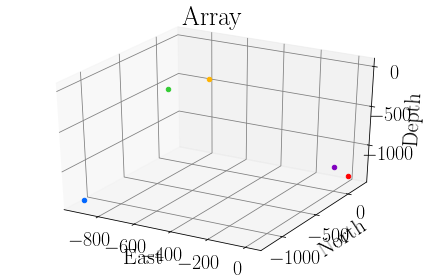

/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


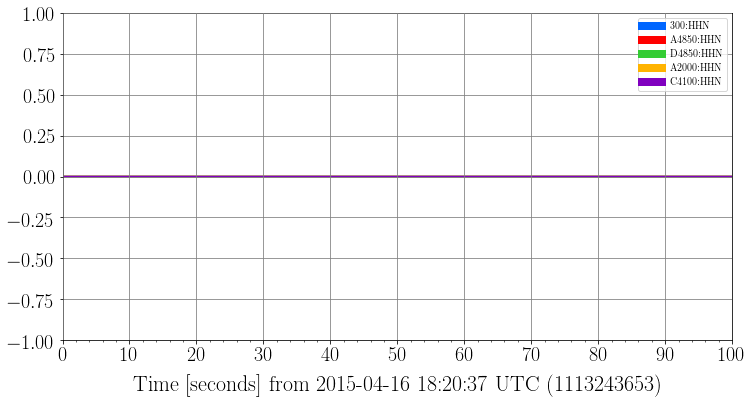

In [4]:
# amplitude = 1e-4
# strs = ['p','r']
# # set up array
# stations = homestake(stationlist)
plot = stations.plot()
plt.title('Array')
plt.tight_layout()
plt.show()
# # get data

EventData = SeismometerArray.fetch_data(st, et,
         framedir='/archive/frames/homestake/', chans_type='fast_chans', stations=stationlist)
PreEventData = SeismometerArray.fetch_data(st-2000, st-1500,
         framedir='/archive/frames/homestake/', chans_type='fast_chans', stations=stationlist)
# for station in stationlist:
#     env = np.abs(EventData[station]['HHZ'].gaussian_filter(freq,0.1).hilbert())
#     envPre = np.abs(PreEventData[station]['HHZ'].gaussian_filter(freq,0.1).hilbert())
#     for chan in ['HHE','HHZ','HHN']:
#         EventData[station][chan] = EventData[station][chan].gaussian_filter(freq,0.1)
#         EventData[station][chan] *= env**(-1)
#         PreEventData[station][chan] = PreEventData[station][chan].gaussian_filter(freq,0.1)
#         PreEventData[station][chan] *= envPre**(-1)
plot = EventData['300']['HHN'].gaussian_filter(1, 0.2).plot()
ax = plot.gca()
ax.plot(EventData['A4850']['HHN'].gaussian_filter(1, 0.3))
ax.plot(EventData['D4850']['HHN'].gaussian_filter(1, 0.3))
ax.plot(EventData['A2000']['HHN'].gaussian_filter(1, 0.3))
ax.plot(EventData['C4100']['HHN'].gaussian_filter(1, 0.3))

ax.set_ylim(-1,1)
plot.add_legend()
plot.show()


    

# # get pre-event data to use for covariance matrix

# print EventData.keys()

# Get cross-correlations

We now take the cross-correlation between stations:

$$Y_{(12)}(f) = \tilde{d}_1(f)^* \times \tilde{d}_2(f)$$

where $\tilde{d}_i(f)$ is the fast-fourier transform of data from seismometer channel $i$. 

In [5]:
# get coherences at 1 Hz
Ys = EventData.get_coherences(freq, fftlength=5, overlap=2.5, window='hann')
PreYs = PreEventData.get_coherences(freq, fftlength=5, overlap=2.5, window='hann')
#Ys = EventData.get_coherences(1, fftlength=100, overlap=50, window='hann')
Y = np.mean(Ys, axis=1)


# Covariance matrix
Get covariance matrix from pre-event data and invert it. 

In [6]:
Ycov = np.cov(PreYs)
N_inv_all = pinv2(Ycov, rcond=1e-5)
# assume product of noise ASDs is roughly 10^-24 (i.e. self nosie is at around 10^-12 m/s/rtHz)
# this isn't quite right for the case we're looking at...but I dont' feel like simulating pre-event data
# right now.
N_inv = np.diag(np.ones(Y.size)) * 1e13 
N = np.diag(np.ones(Y.size))*1e-13

# Get our overlap reduction function

We've shown in the past that if we're trying to estimate the power distribution on the sky, say $H_{S}(\hat\Omega)$ and we decompose that onto some orthonormal basis:

$$ H_{S}(\hat\Omega) = \sum_{a} B_a(\hat\Omega) S_a$$

then our cross-correlation statistic $Y_{(ij)}(f)$ between two arbitrary channels is related to those amplitude components as follows:

$$ Y_{ij}(f) = \sum_{a}\gamma_{(ij),a}S_a$$

In our case, we use pixels as our basis. However, it's useful to keep spherical harmonics in the back of your head as we do this (we'll discuss why later).

Note that $\gamma$ is related to the channel's response to a wave traveling in some direction (and can, in principle, also depend on the depth. This is true for $r$-waves in our model):

$$\gamma_{(ij),a} \equiv \int d\Omega \, B_a(\Omega)\, e_i(\Omega) \, e_j(\Omega) \, e^{2\pi i f(\hat\Omega\cdot\vec\Delta x)/v}$$

where $e_i(\Omega)$ is the dot product of the polarization of wave onto the channel. So for a $p$-wave traveling east and a channel pointing east, this is 1. For an $s$-wave traveling north with pure horizontal polarization and an east channel it is 1.

In our case, we use $B_a(\Omega) = \delta(\Omega,\Omega_0)$, which we call the "pixel basis."

Below we calculate $\gamma$ for each detector pair, and each direction for both $p$-waves and $r$-waves and then stack them.

In the end $G$ is a matrix with dimensions $N_{pairs} \times N_{pixels}$.

In [7]:
# get p-wave matrices for v=5700 for now.
nside=8
G, phis, thetas, shapes = EventData.get_gamma_matrix_healpy('p',
        stations, freq, 6000, nside=nside)
Gs, phis_s, thetas_s, shapes_s = EventData.get_gamma_matrix_healpy('s',stations,freq,4500,nside=nside)
G = np.vstack((G,Gs)).T
Gs = None
strs = ['p','sh','sv']
#print gamma.shape

# Quick check to get lmax

Now we'll do a quick check by doing a matrix inversion to estimate the maximum likelihood parameters for $\phi,\theta,A$ assuming some reasonable velocity. We'll do this to estimate the spot size we need. This will allow us to create a more realistic injection map that we can use to reconstruct the cross-correlation data.

It works as follows:

1. Invert assuming that $S = (\gamma^{\dagger}\gamma)^{-1} \gamma^{\dagger} Y$ to get a "clean map" that gives us an estimate of $\phi,\theta,A$.
2. Create an injected map by injecting into the single pixel corresponding to our initial time-series injection
3. Convert to spherical harmonics *up to some $l_{max}$ associated with our array*
4. Convert back to pixels. We've now lost some information because we only went up to some $l_{max}$.
5. Compare the two maps using a "map cross-correlation."

Once we've done this and established an appropriate $l_{max}$ we can apply it in our likelihood function.

In [8]:
u, s, vh = svd(np.dot(G.T.conj(), G), full_matrices=False, check_finite=False)

In [9]:
cond = 1e-2
rank = np.sum(s > cond * np.max(s))
print rank
psigma_diag = 1.0 / s[: rank]
G_inv = np.transpose(np.conjugate(np.dot(u[:, : rank] *
                                         psigma_diag, vh[: rank])))

36


/home/meyers/opt/seispy/lib/python2.7/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


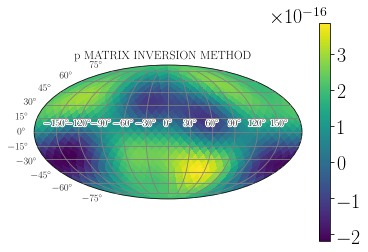

(2.3005239830218631, 0.88357293382212931)


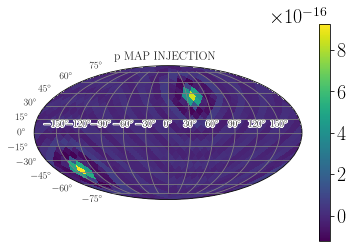

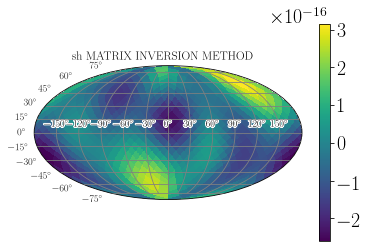

(0.41113786232234778, 2.5525440310417071)


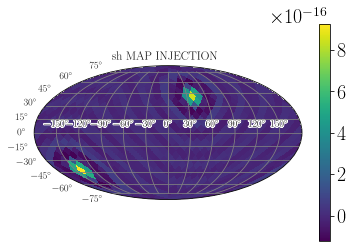

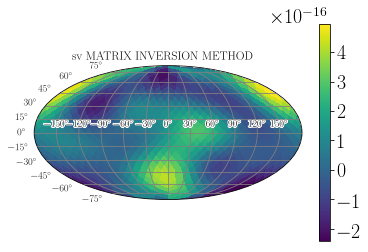

(0.73057374489655236, 3.0293929159615862)


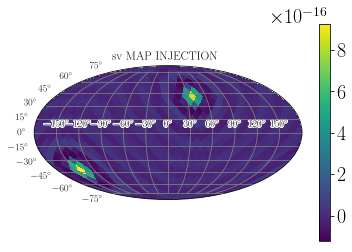

In [10]:
# Do some quick plots:

# Get a quick clean map assuming velocity and look at it doing matrix inversion:
nside=8
S_full = np.real(np.dot(G_inv, np.real(np.dot(G.T.conj(), Y))))
npix = hp.pixelfunc.nside2npix(nside)
idx0=0
for string in strs:
    S = S_full[idx0:idx0+npix]
    ax = plt.subplot(111, projection='mollweide')
    hplot.healpix_heatmap(S, cmap='viridis')
    hplot.outline_text(ax)
    ax.grid(True)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    plt.colorbar()
    ax.set_title(r'%s MATRIX INVERSION METHOD' % string, fontsize=12)
    plt.show()
    print hp.pixelfunc.pix2ang(nside,np.argmax(S))

    inj_map = np.zeros(S.size)
    idx = hp.pixelfunc.ang2pix(nside,2.3560876786680951,3.8222710618675815)
    idx2 = hp.pixelfunc.ang2pix(nside,np.radians(45),np.radians(39))
    inj_map[idx] = 1
    inj_map[idx2] = 0.9
    Plm = pixAnis.clmFromMap_fast(inj_map,14) * 6e-16 * 5
    inj_map = pixAnis.mapFromClm_fast(Plm, nside)

    ax = plt.subplot(111, projection='mollweide')
    hplot.healpix_heatmap(inj_map, cmap='viridis')
    hplot.outline_text(ax)
    ax.grid(True)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    plt.colorbar()
    ax.set_title(r'%s MAP INJECTION' % string, fontsize=12)
    plt.show()
    idx0+=npix

# Bayesian Parameter Estimation

We want to estimate the velocity, direction, and amplitude of the wave at some frequency. We use Bayes' Theorem

$$ p(v,\theta,\phi,A | Y) \propto p(Y | v,\theta,\phi, A)p(v)p(\theta)p(\phi)p(A)$$

In this case, we have the following likelihood

$$ \log p(Y | v,\theta,\phi, A) = -\frac{1}{2} ( Y - \gamma(v) S(\theta,\phi,A))^{\dagger}\,\, N^{-1}\,\, (Y -  \gamma(v) S(\theta,\phi,A)) $$

Note that $N$ in this case is a typical covariance matrix of the seismic field during a quiet time. We're trying to estimate *this events* parameters. 

**NOTE** In general, for the seismic radiometer on quiet times (trying to map general power on the sky) we want the "cleaned" data to be consistent with gaussian nosie. In this case, we're not interested in the ambient seismic field. Just the p-waves from the event.

We choose broad, uniform priors on $v$, $\theta$, $\phi$, and a broad logarithmic prior on $A$ and use an mcmc sampler to evaluate the likelihood for many different values of $v$, $\theta$, and $\phi$. 

In [11]:
# Y_sim = np.dot(G, S)
# res = Y - Y_sim
# logLike = -0.5 * np.dot(np.dot(res.T.conj(), N_inv_all),res)# - 0.5 * (np.log10(2*np.pi) + np.trace(N))
# print logLike
# print np.dot(S,inj_map) / np.sqrt((np.dot(S,S) * np.dot(inj_map,inj_map)))

In [12]:
# do matrix inversion
Y = np.mean(Ys, 1)
nside=4
freq = 5
lmax=4
def logLike(cube, ndim, nparams):
    # get parameters from cube
    phiP, thetaP, vP, AP = cube[0], cube[1], cube[2], cube[3]
    phiSH, thetaSH, vS, ASH = cube[4],cube[5], cube[6], cube[7]
    phiSV, thetaSV, ASV = cube[8], cube[9], cube[10]
    # get gamma
    gammaP, phis, thetas, shapes = EventData.get_gamma_matrix_healpy('p',
        stations, freq, vP, nside=nside)
    gammaS, phis2, thetas2, shapes2 = EventData.get_gamma_matrix_healpy('s', 
        stations, freq, vS, nside=nside)
    gamma = np.vstack((gammaP, gammaS))
    # get test map
    test_mapP = np.zeros(phis.size)
    test_mapSH = np.zeros(phis.size)
    test_mapSV = np.zeros(phis.size)
    # inject into P
    idx = hp.pixelfunc.ang2pix(nside, thetaP, phiP)
    test_mapP[idx] = 1
    Plm = pixAnis.clmFromMap(test_mapP, lmax) * (10**AP)**2 * 5
    test_mapP = pixAnis.mapFromClm(Plm, nside)
    # inject into SH
    idx = hp.pixelfunc.ang2pix(nside, thetaSH, phiSH)
    test_mapSH[idx] = 1
    Plm = pixAnis.clmFromMap(test_mapSH, lmax) * (10**ASH)**2 * 5
    test_mapSH = pixAnis.mapFromClm(Plm, nside)
    #inject into SV
    idx = hp.pixelfunc.ang2pix(nside, thetaSV, phiSV)
    test_mapSV[idx] = 1
    Plm = pixAnis.clmFromMap(test_mapSV, lmax) * (10**ASV)**2 * 5
    test_mapSV = pixAnis.mapFromClm(Plm, nside)
    # stack
    test_map = np.hstack((test_mapP,test_mapSH,test_mapSV))
    dat = (Y - np.dot(gamma.T, test_map))
    return -0.5 * np.real(np.dot(np.dot(dat.T.conj(), 10**-3 * N_inv_all), dat))
def prior(cube, ndim, nparams):
    ## P
    # phi
    cube[0] = 2 * np.pi * cube[0]
    # theta
    cube[1] = np.pi *  cube[1]
    # v
    cube[2] = 2000 + 5000 * cube[2]
    # amp
    cube[3] = -9 + cube[3]*4
    ## SH
    # phi
    cube[4] = 2 * np.pi * cube[4]
    # theta
    cube[5] = np.pi/2. *  cube[5]
    # vS
    cube[6] = 2000 + 5000 * cube[6]
    # amp
    cube[7] = -9 + cube[7]*4
    ## SV
    # phi
    cube[8] = 2 * np.pi * cube[8]
    # theta
    cube[9] = np.pi/2. *  cube[9]
    # amp
    cube[10] = -9 + cube[10]*4
    return cube
    #cube[4] = 0.5 + 0.5 * cube[4]
print logLike(prior([0.5, 0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5], 11,11), 11,11)

-1518975.94161


In [13]:
# # likes = np.zeros(192)
# # vs = np.arange(20) * 100 + 5000
# # for ii in range(192):
# #     theta, phi = hp.pixelfunc.pix2ang(4,ii)
# #     likes[ii] = logLike([phi, theta, 5700],2,2)
# import math
# import scipy.special as ss
# mm = np.asarray([-2.,-1.,0,1.,2.])
# ll = np.asarray([2,2,2,2,2])
# phis = np.asarray([np.pi,np.pi])
# thetas = np.asarray([np.pi/2.,np.pi/2.])
# test = ss.sph_harm(mm,ll, phis, thetas)
# test2 = ss.sph_harm(-mm,ll,phis,thetas)
# testf = np.zeros(test.size)
# testf[mm>0] = (1/np.sqrt(2)) * (test[mm>0] + (-1)**(mm[mm>0]) * test2[mm>0])
# testf[mm<0] = 1/(np.sqrt(2) * 1j) * (test2[mm<0] - (-1)**(-mm[mm<0]) * test[mm<0])
# print testf

# def real_sph_harm(mm, ll, phi, theta):
#     """
#     The real-valued spherical harmonics.
#     """

#     if mm>0:
#         ans = (1./np.sqrt(2)) * \
#                 (ss.sph_harm(mm, ll, phi, theta) + \
#                 ((-1)**mm) * ss.sph_harm(-mm, ll, phi, theta))
#     elif mm==0:
#         ans = ss.sph_harm(0, ll, phi, theta)
#     elif mm<0:
#         ans = (1./(np.sqrt(2)*complex(0.,1))) * \
#                 (ss.sph_harm(-mm, ll, phi, theta) - \
#                 ((-1)**mm) * ss.sph_harm(mm, ll, phi, theta))

#     return ans.real
# print real_sph_harm(-2,2,np.pi,np.pi/2)
    

In [14]:
# angmarg = likes.sum(axis=1)
# vmarg = likes.sum(axis=0)
# print 'ML direction (phi, theta):'
# print np.degrees(hp.pixelfunc.pix2ang(4,np.where(likes==np.max(likes.flatten()))[0]))
# print 'ML velocity: %f' % vs[np.where(likes==np.max(likes.flatten()))[1]]

In [ ]:
# ax = plt.subplot(111, projection='mollweide')
# hplot.healpix_heatmap(likes, cmap='viridis')
# hplot.outline_text(ax)
# ax.grid(True)
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(10)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(10)
# plt.colorbar()
# ax.set_title(r'Marginalized posterior on direction', fontsize=12)
# plt.show()

# plt.plot(vs, vmarg)
# plt.xlabel('p-wave velocity [m/s]')
# plt.ylabel('log likelihood')
# plt.title('Marginalized posterior on velocity')
# plt.show()
        

In [ ]:
pymultinest.run(logLike, prior, 11, n_live_points=600, verbose=True, resume=True)

In [ ]:
dat = np.loadtxt('chains/1-post_equal_weights.dat')
figure = corner(dat[:, :5], labels=['$\phi$ [rad]', '$\\theta$ [rad]', 'Velocity [m/s]', '$\log$ Amp [m/s]', 'r'], quantiles =
        [0.16, 0.5, 0.84], show_titles=True, title_kwargs={'fontsize': 12})
plt.show()
figure.savefig("mycorner.png")

In [ ]:
print np.min(dat[:,0])

#### 